In [1]:
import argparse
import datetime
import logging
import os
import pdb

import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hwtmode.data import decompose_circular_feature
from matplotlib.colors import BoundaryNorm, ListedColormap

sns.set_theme()
import xarray

from ml_functions import (
    assertclose,
    brier_skill_score,
    configs_match,
    get_argparser,
    get_features,
    get_ifiles,
    load_df,
    rptdist2bool,
)

logging.basicConfig(format="%(asctime)s %(message)s", level=logging.INFO)

2023-12-15 08:32:38.281107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 08:32:38.524487: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = get_argparser()
args, argv = parser.parse_known_args()
args.batchnorm = True
args.model = "HRRR"
# args.ifile = 'HRRR/HRRRXHRRR.par'
args.epochs = 30
args.debug = False
args.flash = 1
args.glm = True
args.twin = 1
args.kfold = 1
args.labels = [f"{f}_{r}km_{args.twin}hr" for r in [20,40] for f in ["cg","ic","cg.ic","flashes"] ]
args.layers = 1
args.learning_rate = 0.001
args.neurons = [1024]
args.optimizer = "Adam"
args.reg_penalty = 0
args.suite = "default"
args.teststart = pd.to_datetime("20201202T12")
args.testend = pd.to_datetime("20220101")
args.trainstart = pd.to_datetime("19000101")
args.trainend = pd.to_datetime("20201202")

In [3]:
args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, labels=['cg_20km_1hr', 'ic_20km_1hr', 'cg.ic_20km_1hr', 'flashes_20km_1hr', 'cg_40km_1hr', 'ic_40km_1hr', 'cg.ic_40km_1hr', 'flashes_40km_1hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=10, folds=None, kfold=1, idate=None, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='Adam', reg_penalty=0, savedmodel=None, seed=None, trainend=Timestamp('2020-12-02 00:00:00'), trainstart=Timestamp('1900-01-01 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), teststart=Timestamp('2020-12-02 12:00:00'), twin=1, suite='default', glm=True, layers=1)

In [4]:
%time
rptdist = 20
logging.info("load wbug lightning data")
wbugdir = "/glade/campaign/mmm/parc/ahijevyc/wbug_lightning"
wbug = xarray.open_dataset(
    os.path.join(wbugdir, f"flash.{rptdist}km_30min.nc"), chunks=None
)
wbug["cg.ic"] = wbug.cg + wbug.ic
wbug

2023-12-15 08:32:49,150 load wbug lightning data


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.29 µs


<xarray.Dataset>
Dimensions:              (time_coverage_start: 94326, y: 129, x: 185)
Coordinates:
  * time_coverage_start  (time_coverage_start) datetime64[ns] 2018-01-01 ... ...
    lon                  (y, x) float64 ...
    lat                  (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables:
    cg                   (time_coverage_start, y, x) float64 ...
    ic                   (time_coverage_start, y, x) float64 ...
    cg.ic                (time_coverage_start, y, x) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    ellps:    WGS84
    proj:     lcc
    lon_0:    -95
    lat_0:    39.0
    x_0:      0.0
    y_0:      0.0
    lat_1:    25
    lat_2:    25

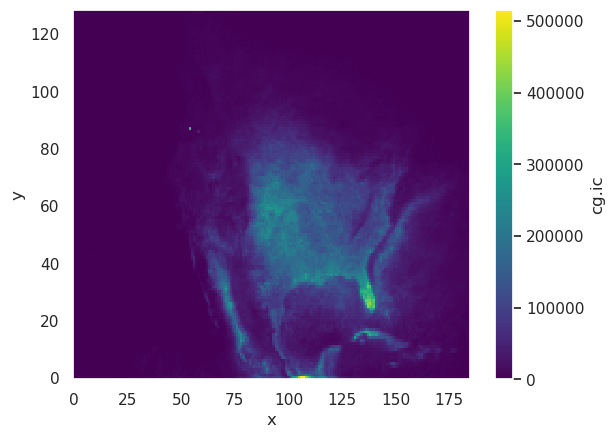

In [5]:
wbug["cg.ic"].sum(dim="time_coverage_start").plot()

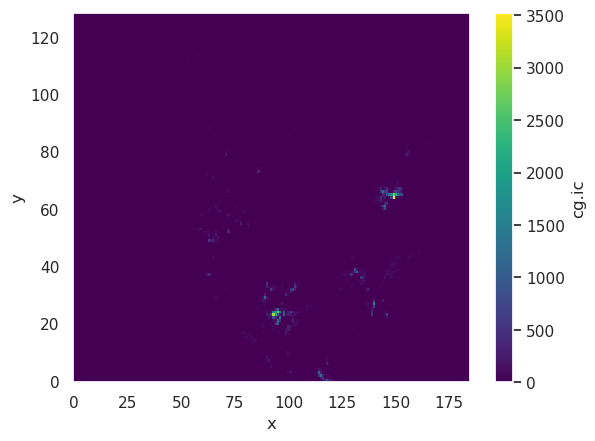

In [7]:
time_range = slice("20210721T1600", "20210721T1930")
wbug.sel(time_coverage_start=time_range).sum(dim="time_coverage_start")["cg.ic"].plot()

In [7]:
y, x = 32, 66
# i = wbug.isel(y=y, x=x).idxmax()
time_range = slice("20180806T0400", "20180806T0730")
wbug.isel(y=y, x=x).sel(time_coverage_start=time_range).ic.compute()

<xarray.DataArray 'ic' (time_coverage_start: 8)>
array([   0.,    0.,   92., 1152., 1462.,  492.,  216.,   43.])
Coordinates:
  * time_coverage_start  (time_coverage_start) datetime64[ns] 2018-08-06T04:0...
    lon                  float64 -110.8
    lat                  float64 28.45

In [10]:
%time
twin = args.twin
offset = pd.Timedelta(hours=twin / 2) if twin == 1 else None
wbug1 = (
    wbug.sel(
        time_coverage_start=slice(
            pd.to_datetime("20181101T00"), pd.to_datetime("20181111T13")
        )
    )
    .resample(
        time_coverage_start=f"{twin}H",
        offset=offset,
        skipna=True,  # True in ml_functions
    )
    .mean()
    * twin
    * 2
)

valid_time = wbug1.time_coverage_start.data + pd.Timedelta(hours=twin / 2)
wbug1 = (
    wbug1.assign_coords({"valid_time": ("time_coverage_start", valid_time)})
    .swap_dims({"time_coverage_start": "valid_time"})
    .ic
)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


In [25]:
%time
wbug2 = (
    (
        # If you shift with missing times, shifting by constant index is not constant in time.
        # Therefore, resample at 30-min interval. fill in missing 30-minute times with nans
        wbug.sel(
            time_coverage_start=slice(
                pd.to_datetime("20181101T00"), pd.to_datetime("20181111T13")
            )
        )
        .resample(time_coverage_start="30T")
        .first()
        .shift(time_coverage_start=-twin * 2 + 1)
        .rolling(
            dim={"time_coverage_start": twin * 2},
            min_periods=twin,
        )
        .mean()
        * twin
        * 2
    )
    .resample(time_coverage_start=f"1H", offset="30T" if twin == 1 else None).first()
    # tried coarsen - dask's resample is inefficient https://github.com/pydata/xarray/discussions/5753
    # but couldnt use .first(); only mean() or median, which is not what I want.
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [26]:
valid_time = wbug2.time_coverage_start.data + pd.Timedelta(hours=twin / 2)
wbug2 = (
    wbug2.assign_coords(valid_time=("time_coverage_start", valid_time))
    .swap_dims({"time_coverage_start": "valid_time"})
    .ic
)

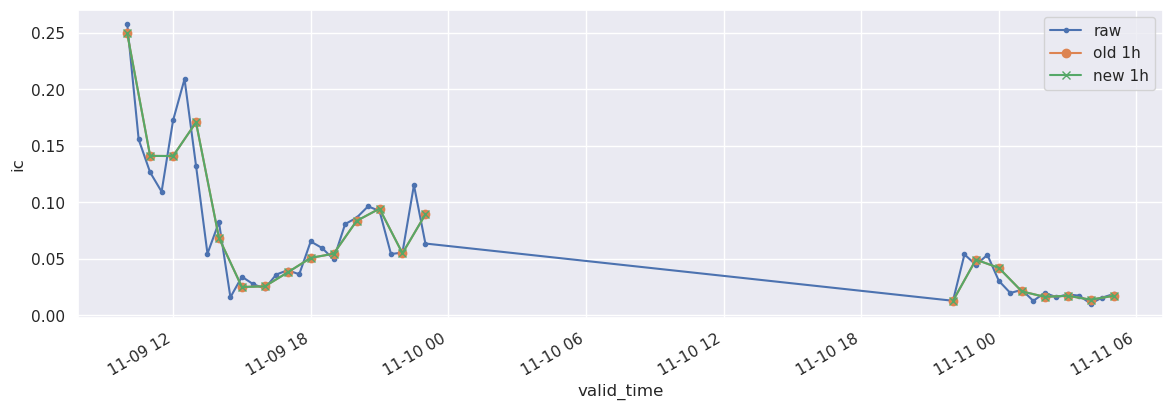

In [27]:
trange = slice(pd.to_datetime("20181109T10"), pd.to_datetime("20181111T05"))
fig, ax = plt.subplots(figsize=(14, 4))
(wbug.ic.sel(time_coverage_start=trange) * twin*2).mean(dim=["y", "x"]).plot(
    marker=".", label="raw"
)
wbug1.sel(valid_time=trange).mean(dim=["y", "x"]).plot(ax=ax, marker="o", label=f"old {twin}h")
wbug2.sel(valid_time=trange).mean(dim=["y", "x"]).plot(ax=ax, marker="x", label=f"new {twin}h")
plt.legend()

In [28]:
df = load_df(args, wbugdir="/glade/campaign/mmm/parc/ahijevyc/wbug_lightning")

2023-12-15 08:53:35,313 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.1hr.par 35.7G mtime Thu Dec 14 18:07:19 2023 240 features 8 labels and 4 index_cols & dropna.


In [33]:
df.head(10000)[::1308]

,CAPESHEAR,CAPESHEAR-N3T1,CAPESHEAR-N3T3,CAPESHEAR-N3T5,CAPESHEAR-N5T1,CAPESHEAR-N5T3,CAPESHEAR-N5T5,CREF,CREF-N3T1,CREF-N3T3,...,cg.ic_20km_1hr,flashes_20km_1hr,cg_40km_1hr,ic_40km_1hr,cg.ic_40km_1hr,flashes_40km_1hr,initialization_time,valid_time,y,x
pt,,,,,,,,,,,,,,,,,,,,,
1,1767.816406,3000.392578,3177.105957,3501.222900,4059.996826,4213.809082,4428.125000,-9.294667,-8.962192,-8.145061,...,False,False,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 02:00:00,12,48
1,1741.757324,3041.015381,3144.277100,3382.853516,4213.750977,4255.433105,4422.460938,-10.000000,-9.686814,-8.962192,...,False,False,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 03:00:00,12,48
1,1829.926025,3391.423828,3474.655029,3644.268066,4492.552246,4561.542480,4681.601074,-10.000000,-9.629458,-9.036094,...,False,False,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 04:00:00,12,48
1,1898.589478,3991.525635,4059.977539,4133.328613,4978.324707,5044.752441,5114.850586,-10.000000,-9.036094,-7.945816,...,False,False,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 05:00:00,12,48
1,2338.633789,4796.982910,4744.734863,4773.835449,5663.380859,5622.649902,5628.178223,-10.000000,-7.945816,-7.945816,...,False,False,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 06:00:00,12,48
1,3167.661865,5445.694824,5495.409180,5534.027832,6226.244141,6223.337402,6200.187012,-10.000000,-8.951903,-5.839163,...,False,False,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 07:00:00,12,48
1,4560.557617,6243.549805,6293.876953,6255.897949,6780.387695,6786.410156,6709.833984,-10.000000,-5.839163,-5.839163,...,False,False,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 08:00:00,12,48
1,6352.519043,7192.384766,7012.270996,6817.945801,7352.598145,7219.848145,7064.835449,-9.965192,-5.955247,-5.794839,...,False,False,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 09:00:00,12,48


In [29]:
dfb = rptdist2bool(df, args)

2023-12-15 08:57:59,949 use [0, 1, 2] time win for 8 lsrtypes until parquet renamed [1,2,4]
2023-12-15 08:57:59,952 Convert severe report distance to boolean [0,20km) = True
2023-12-15 08:57:59,954 threshold wbug at 10 flashes
2023-12-15 08:59:07,497 use [0, 1, 2] time win for 8 lsrtypes until parquet renamed [1,2,4]
2023-12-15 08:59:07,501 Convert severe report distance to boolean [0,40km) = True
2023-12-15 08:59:07,503 threshold wbug at 10 flashes


KeyboardInterrupt: 

In [34]:
dfb[label_cols]  # .loc[(time_range,slice(None),slice(None))]

sighail_40km_0hr  sighail_40km_1hr  \
valid_time          y  x                                        
2020-06-01 01:00:00 12 48             False             False   
                       49             False             False   
                       69             False             False   
                       70             False             False   
                    13 47             False             False   
...                                     ...               ...   
2020-07-02 00:00:00 46 25             False             False   
                       26             False             False   
                       27             False             False   
                       28             False             False   
                       29             False             False   

                           sighail_40km_2hr  sigwind_40km_0hr  \
valid_time          y  x                                        
2020-06-01 01:00:00 12 48             False             False   
                       49             False             False   
                       69             False             False   
                       70             False             False   
                    13 47             False             False   
...                                     ...               ...   
2020-07-02 00:00:00 46 25             False             False   
                       26             False             False   
                       27             False             False   
                       28             False             False   
                       29             False             False   

                           sigwind_40km_1hr  sigwind_40km_2hr  \
valid_time          y  x                                        
2020-06-01 01:00:00 12 48             False             False   
                       49             False             False   
                       69             False             False   
                       70             False             False   
                    13 47             False             False   
...                                     ...               ...   
2020-07-02 00:00:00 46 25             False             False   
                       26             False             False   
                       27             False             False   
                       28             False             False   
                       29             False             False   

                           hailone_40km_0hr  hailone_40km_1hr  \
valid_time          y  x                                        
2020-06-01 01:00:00 12 48             False             False   
                       49             False             False   
                       69             False             False   
                       70             False             False   
                    13 47             False             False   
...                                     ...               ...   
2020-07-02 00:00:00 46 25             False             False   
                       26             False             False   
                       27             False             False   
                       28             False             False   
                       29             False             False   

                           hailone_40km_2hr  wind_40km_0hr  ...  \
valid_time          y  x                                    ...   
2020-06-01 01:00:00 12 48             False          False  ...   
                       49             False          False  ...   
                       69             False          False  ...   
                       70             False          False  ...   
                    13 47             False          False  ...   
...                                     ...            ...  ...   
2020-07-02 00:00:00 46 25             False          False  ...   
                       26             Fa

In [14]:
dfb[label_cols].mean(axis=0)

sighail_40km_1hr    0.000081
sigwind_40km_1hr    0.000149
hailone_40km_1hr    0.000545
wind_40km_1hr       0.001414
torn_40km_1hr       0.000165
any_40km_1hr        0.001876
cg_40km_1hr         0.016368
ic_40km_1hr         0.024419
cg.ic_40km_1hr      0.024668
flashes_40km_1hr    0.025357
dtype: float64

In [9]:
dfb[label_cols].mean(axis=0)

sighail_40km_2hr    0.000131
sigwind_40km_2hr    0.000244
hailone_40km_2hr    0.000866
wind_40km_2hr       0.002245
torn_40km_2hr       0.000267
any_40km_2hr        0.002955
cg_40km_2hr         0.025862
ic_40km_2hr         0.036391
cg.ic_40km_2hr      0.036730
flashes_40km_2hr    0.037705
dtype: float64

In [12]:
df_test = dfb[
    (dfb.initialization_time >= args.teststart)
    & (dfb.initialization_time <= args.testend)
]

<AxesSubplot: xlabel='forecast_hour'>

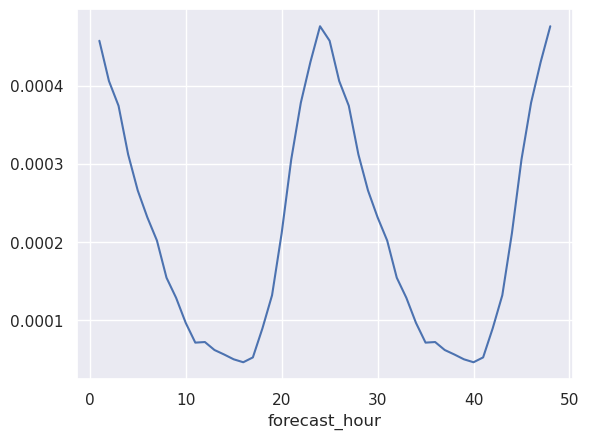

In [14]:
df_test.groupby("forecast_hour")["sigwind_40km_2hr"].mean().plot()

In [6]:
df.loc[("2020-06-20 00:00:00", 46, 25)]

/glade/scratch/ahijevyc/ipykernel_35598/2493454664.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[("2020-06-20 00:00:00", 46,25)]


,initialization_time,forecast_hour,SBCAPE,MLCAPE,SBCINH,MLCINH,UP_HELI_MAX,UP_HELI_MAX03,UP_HELI_MIN,W_UP_MAX,...,sigwind_rptdist_1hr,sigwind_rptdist_2hr,dayofyear_sin,dayofyear_cos,Local_Solar_Hour_sin,Local_Solar_Hour_cos,cg_40km_hourly,ic_40km_hourly,flashes_40km_1hr,flashes_40km_2hr
valid_time,,,,,,,,,,,,,,,,,,,,,
2020-06-20,2020-06-19,24,1364.156372,1219.958862,-75.882027,-79.192047,28.0,16.6,-10.000000,15.066498,...,267,229,0.18176,-0.983343,-0.983879,-0.178835,97.0,1418.0,982.0,1298.0
2020-06-20,2020-06-18,48,1554.019165,1566.556885,-88.998627,-78.573387,63.0,18.0,-38.599998,40.062500,...,267,229,0.18176,-0.983343,-0.983879,-0.178835,97.0,1418.0,982.0,1298.0


In [7]:
df.xs(
    slice("2020-06-20 00:00:00", "2020-06-20 00:00:00"),
    level="valid_time",
    drop_level=False,
).xs(46, level="y", drop_level=False).xs(25, level="x", drop_level=False)

initialization_time  forecast_hour       SBCAPE       MLCAPE  \
valid_time y  x                                                                 
2020-06-20 46 25          2020-06-19             24  1364.156372  1219.958862   
              25          2020-06-18             48  1554.019165  1566.556885   

                     SBCINH     MLCINH  UP_HELI_MAX  UP_HELI_MAX03  \
valid_time y  x                                                      
2020-06-20 46 25 -75.882027 -79.192047         28.0           16.6   
              25 -88.998627 -78.573387         63.0           18.0   

                  UP_HELI_MIN   W_UP_MAX  ...  sigwind_rptdist_1hr  \
valid_time y  x                           ...                        
2020-06-20 46 25   -10.000000  15.066498  ...                  267   
              25   -38.599998  40.062500  ...                  267   

                  sigwind_rptdist_2hr  dayofyear_sin  dayofyear_cos  \
valid_time y  x                                                       
2020-06-20 46 25                  229        0.18176      -0.983343   
              25                  229        0.18176      -0.983343   

                  Local_Solar_Hour_sin  Local_Solar_Hour_cos  cg_40km_hourly  \
valid_time y  x                                                                
2020-06-20 46 25             -0.983879             -0.178835            97.0   
              25             -0.983879             -0.178835            97.0   

                  ic_40km_hourly  flashes_40km_1hr  flashes_40km_2hr  
valid_time y  x                                                       
2020-06-20 46 25          1418.0             982.0            1298.0  
              25          1418.0             982.0            1298.0  

[2 rows x 350 columns]

In [8]:
mdf = dfb[label_cols].groupby(["y", "x"]).sum()  # for debug plot

/glade/scratch/ahijevyc/ipykernel_35598/3253233699.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[["initialization_time","forecast_hour","ic_40km_hourly"]].groupby("forecast_hour").mean().plot()


<AxesSubplot: xlabel='forecast_hour'>

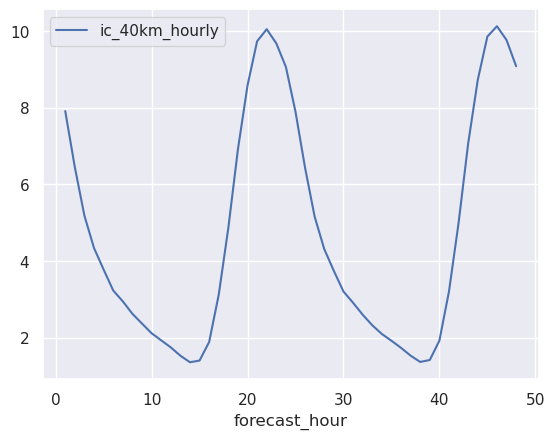

In [9]:
df[["initialization_time", "forecast_hour", "ic_40km_hourly"]].groupby(
    "forecast_hour"
).mean().plot()

/glade/scratch/ahijevyc/ipykernel_35598/246027149.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfb[["initialization_time","forecast_hour","ic_40km_2hr"]].groupby("forecast_hour").mean().plot()


<AxesSubplot: xlabel='forecast_hour'>

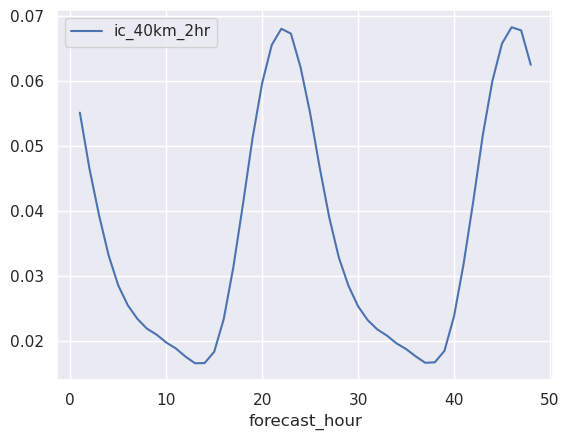

In [10]:
dfb[["initialization_time", "forecast_hour", "ic_40km_2hr"]].groupby(
    "forecast_hour"
).mean().plot()

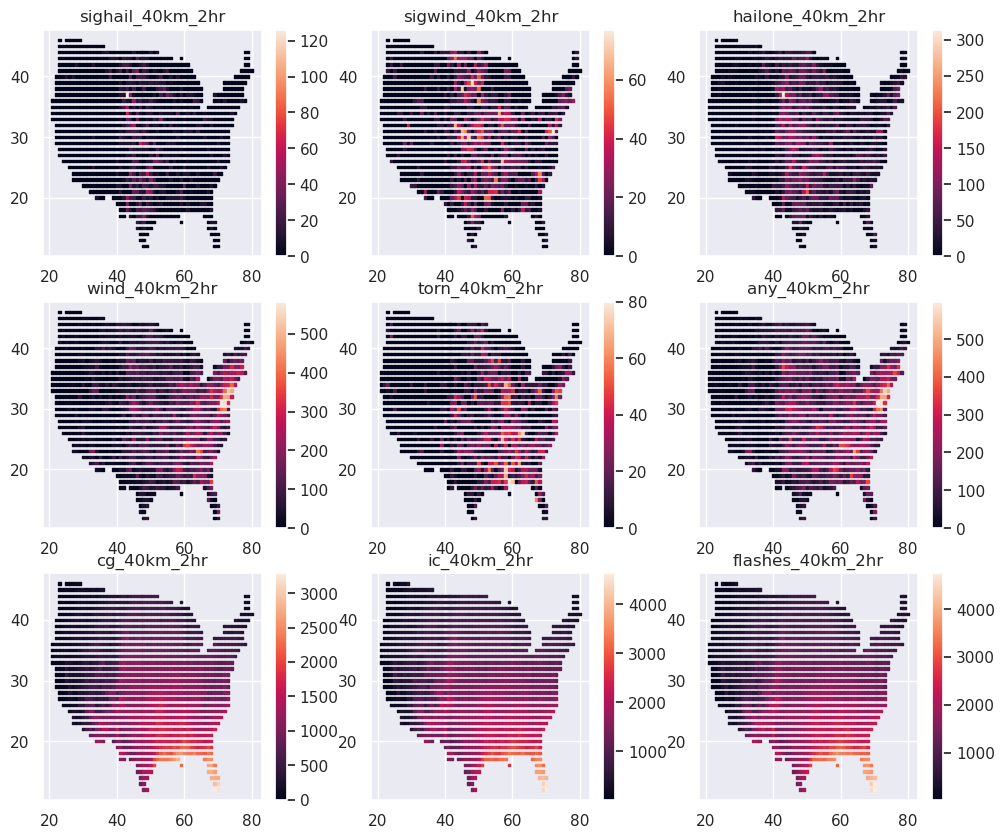

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
for label, ax in zip(label_cols, axes.flatten()):
    im = ax.scatter(
        mdf.index.get_level_values("y"),
        mdf.index.get_level_values("x"),
        c=mdf[label],
        s=3,
        marker="s",
    )  # Don't use mdf (sum) for lon/lat
    ax.set_title(label)
    fig.colorbar(im, ax=ax)